In [ ]:
! pip install scikeras
! pip install git+https://github.com/modAL-python/modAL.git
# !pip install --upgrade scikit-learn scikeras

## **Imports**

In [2]:
import os
import cv2
import keras
import numpy as np
import seaborn as sns
from keras.layers import Dense
from keras.models import Model
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from sklearn.utils import resample
from modAL.models import ActiveLearner
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split
from modAL.disagreement import consensus_entropy_sampling
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from modAL.uncertainty import entropy_sampling,margin_sampling,uncertainty_sampling
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

## **Loading Images**

In [3]:
dataset_dir = "/kaggle/input/flowers/"
def load_flower_dataset(dataset_dir, desired_width, desired_height):
    classes = os.listdir(dataset_dir)
    X = []
    y = []
    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(dataset_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            # Read the image using OpenCV
            image = cv2.imread(image_path)
            # Resize the image to a fixed size
            image = cv2.resize(image, (desired_width, desired_height))
            # Append the image and its label to the lists
            X.append(image)
            y.append(idx)  # Use the index of the class as the label
    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)
    return X, y

desired_width = 224 
desired_height = 224

## **Defining the Model**

In [4]:
def create_keras_model():
    Input_Layer = Input(shape=(224, 224, 3))
    MobileNet_Model = keras.applications.MobileNet(
                                                    alpha=1.0,
                                                    depth_multiplier=1,
                                                    dropout=0.001,
                                                    include_top=False,
                                                    weights="imagenet",
                                                    input_tensor=Input_Layer
                                                   )
    MobileNet_Model.trainable = False
    
    Pooled_output = GlobalAveragePooling2D()(MobileNet_Model.output)
    Densed_output = Dense(128, activation='tanh')(Pooled_output)
    Output_Layer = Dense(5, activation = 'softmax')(Densed_output)

    mobile_model = Model(inputs = MobileNet_Model.input, outputs = Output_Layer)
    mobile_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return mobile_model

## **Defining the Random Sampling Function**

In [5]:
def random_sampling(classifier, X_pool, n_instances):
    query_idx = np.random.choice(range(len(X_pool)), size=n_instances, replace=False)
    return query_idx, X_pool[query_idx]

## **Defining the Imbalancing Function**

In [6]:
def make_dataset_unbalanced(X, y, target_class_samples):
    # Count the number of samples in each class
    class_counts = np.bincount(y)

    # Identify the majority and minority classes
    majority_class = np.argmax(class_counts)
    minority_classes = np.arange(len(class_counts))[class_counts < class_counts[majority_class]]

    # Resample the majority class to create class imbalance
    unbalanced_data = [(X[y == majority_class], y[y == majority_class])]  # Keep the majority class data as is
    for minority_class in minority_classes:
        num_samples_to_remove = class_counts[minority_class] - target_class_samples[minority_class]
        if num_samples_to_remove > 0:
            # Randomly remove samples from the minority class
            resampled_X, resampled_y = resample(X[y == minority_class], y[y == minority_class], 
                                                 replace=False, n_samples=target_class_samples[minority_class], 
                                                 random_state=42)
            unbalanced_data.append((resampled_X, resampled_y))

    # Concatenate the resampled data
    unbalanced_X = np.concatenate([data[0] for data in unbalanced_data])
    unbalanced_y = np.concatenate([data[1] for data in unbalanced_data])

    return unbalanced_X, unbalanced_y

## **Defining the Splitting Function**

In [7]:
def initialize_data(train_size_fraction, dataset_dir, desired_width, desired_height):
    X, y = load_flower_dataset(dataset_dir, desired_width, desired_height)
    
    # Specify the desired number of samples for each class
    target_class_samples = {
        0: 20,
        1: 50,
        2: 20,
        3: 30,
        4: 50,
    }

    # Apply the function to make the dataset unbalanced
    X_unbalanced, y_unbalanced = make_dataset_unbalanced(X, y, target_class_samples)

    # Print the shape of unbalanced_data
    print("Shape of unbalanced data:", X_unbalanced.shape, y_unbalanced.shape)

    # Assuming X_unbalanced and y_unbalanced are your data arrays
    X_train, X_test, y_train, y_test = train_test_split(X_unbalanced, y_unbalanced, test_size=0.2, stratify=y_unbalanced, random_state=42)

    # Split X_train into initial and pool parts
    X_initial, X_pool, y_initial, y_pool = train_test_split(X_train, y_train, test_size=0.60, stratify=y_train, random_state=42)

    # Return the datasets
    return X_initial, y_initial, X_pool, y_pool, X_test, y_test

## **Defining the Active Learning Function**

In [8]:
def active_learning_strategy(query_strategy , X_initial, y_initial, X_pool, y_pool, X_test, y_test):
    classifier = KerasClassifier(create_keras_model, batch_size=1)
    learner = ActiveLearner(estimator=classifier, query_strategy=query_strategy, X_training=X_initial, y_training=y_initial, verbose=1)
    f1_scores = []
    accuracies = []
    for idx in range(10):
        query_idx, _ = learner.query(X_pool, n_instances=40)
        learner.teach(X=X_pool[query_idx], y=y_pool[query_idx], only_new=False, verbose=1)
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)

        y_pred = learner.predict(X_test)

        f1 = f1_score(y_test, y_pred, average='weighted')
        f1_scores.append(f1)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

        print(f"\033[1mIteration {idx + 1}:\033[0m \n\033[1mF1 Score\033[0m: {f1}")
        print("\033[1mAccuracy:\033[0m", accuracy)
        print()

        plt.figure(figsize=(5, 4))
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Oranges', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
        plt.title(f'Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()

    return f1_scores, accuracies

## **Defining the Plotting Function**

In [9]:
def plot_metrics(f1_scores, accuracies, strategy_name):
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    axs[0].plot(range(len(f1_scores)), f1_scores, marker='o')
    axs[0].set_xlabel('Active Learning Cycle')
    axs[0].set_ylabel('F1score')
    axs[0].set_title(f'F1score Improvement through the Active Learning Cycle Using {strategy_name}')
    axs[0].grid(True)

    axs[1].plot(range(len(accuracies)), accuracies, marker='o')
    axs[1].set_xlabel('Active Learning Cycle')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title(f'Accuracy Improvement through the Active Learning Cycle Using {strategy_name}')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

## **Splitting the Data**

In [10]:
train_size_fraction = 0.8  
X_initial, y_initial, X_pool, y_pool, X_test, y_test = initialize_data(train_size_fraction, dataset_dir, desired_width, desired_height)

Shape of unbalanced data: (1202, 224, 224, 3) (1202,)


## **Data Distribution and Statistical Overview**

In [11]:
print("initial_X shape:", X_initial.shape)
print("initial_Y shape:", y_initial.shape)
print("X_pool shape:", X_pool.shape)
print("y_pool shape:", y_pool.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("Unique values in y_test:", np.unique(y_test))
print("First 5 samples of y_test:", y_test[:5])

print("---------------------------------------------------------------------")
print("Samples Distribution in pool part: ")
# Assuming y_initial is a numpy array of labels
unique_classes, class_counts = np.unique(y_pool, return_counts=True)

for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} samples")
print("---------------------------------------------------------------------")
print("Samples Distribution in Initial part: ")
# Assuming y_initial is a numpy array of labels
unique_classes, class_counts = np.unique(y_initial, return_counts=True)

for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} samples")    
    
print("---------------------------------------------------------------------")
print("Samples Distribution in test part: ")
unique_classes, class_counts = np.unique(y_test, return_counts=True)

for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} samples")    

initial_X shape: (384, 224, 224, 3)
initial_Y shape: (384,)
X_pool shape: (577, 224, 224, 3)
y_pool shape: (577,)
X_test shape: (241, 224, 224, 3)
y_test shape: (241,)
Unique values in y_test: [0 1 2 3 4]
First 5 samples of y_test: [0 0 0 0 0]
---------------------------------------------------------------------
Samples Distribution in pool part: 
Class 0: 505 samples
Class 1: 24 samples
Class 2: 10 samples
Class 3: 14 samples
Class 4: 24 samples
---------------------------------------------------------------------
Samples Distribution in Initial part: 
Class 0: 336 samples
Class 1: 16 samples
Class 2: 6 samples
Class 3: 10 samples
Class 4: 16 samples
---------------------------------------------------------------------
Samples Distribution in test part: 
Class 0: 211 samples
Class 1: 10 samples
Class 2: 4 samples
Class 3: 6 samples
Class 4: 10 samples


## **The Active Learning Cycle Using Random Sampling**

Running active learning using random sampling strategy: 


<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
384/384 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8661 - loss: 0.8597


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8516 - loss: 0.8206
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 1: 
F1 Score: 0.8174090258142694
Accuracy: 0.8755186721991701



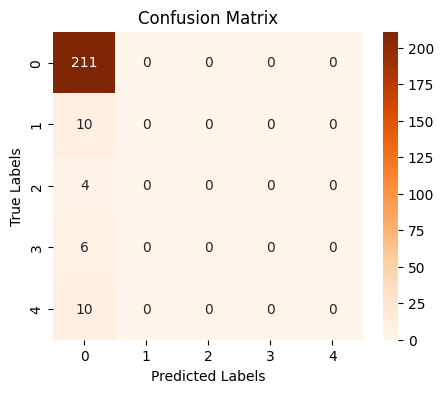

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


464/464 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8463 - loss: 0.8454
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 2: 
F1 Score: 0.8174090258142694
Accuracy: 0.8755186721991701



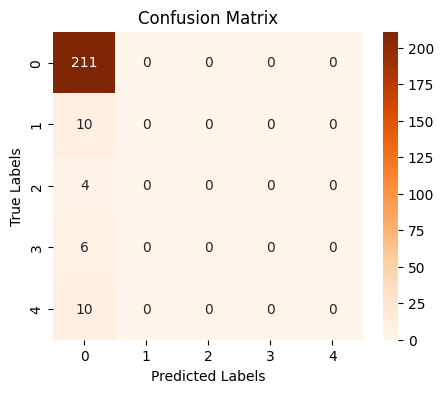

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


504/504 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8611 - loss: 0.7509
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Iteration 3: 
F1 Score: 0.8174090258142694
Accuracy: 0.8755186721991701



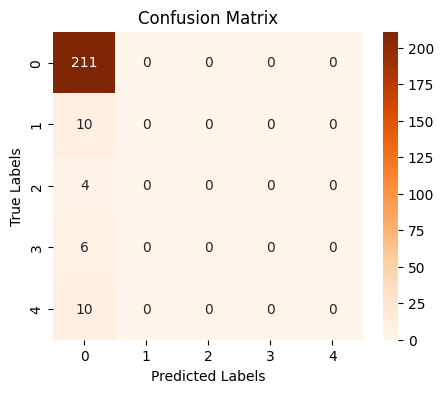

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


544/544 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8708 - loss: 0.7655
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 4: 
F1 Score: 0.8242907251949219
Accuracy: 0.8672199170124482



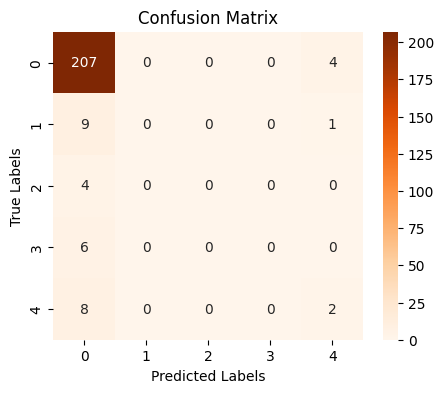

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


584/584 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8566 - loss: 0.6065
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 5: 
F1 Score: 0.8174090258142694
Accuracy: 0.8755186721991701



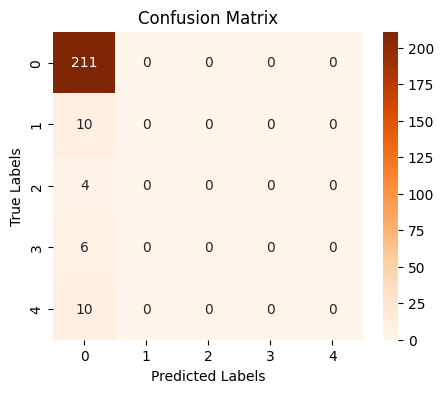

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8649 - loss: 0.7347
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 6: 
F1 Score: 0.8174090258142694
Accuracy: 0.8755186721991701



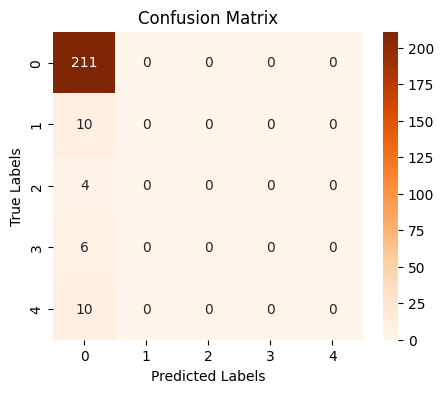

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


664/664 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8653 - loss: 0.7007
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 7: 
F1 Score: 0.8174090258142694
Accuracy: 0.8755186721991701



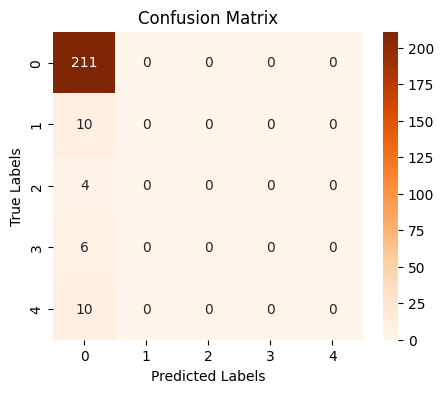

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8383 - loss: 0.7446
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 8: 
F1 Score: 0.8174090258142694
Accuracy: 0.8755186721991701



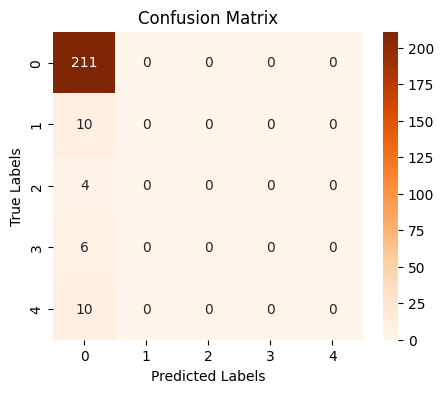

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


744/744 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8492 - loss: 0.7286
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 9: 
F1 Score: 0.8174090258142694
Accuracy: 0.8755186721991701



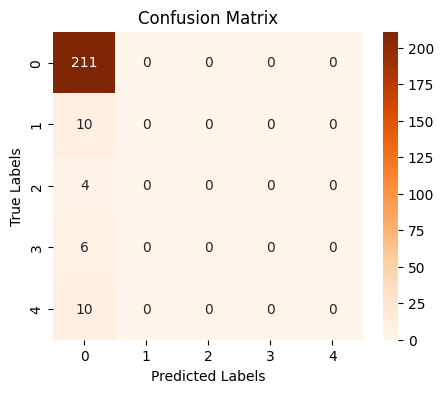

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


784/784 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8702 - loss: 0.6779
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 10: 
F1 Score: 0.8174090258142694
Accuracy: 0.8755186721991701



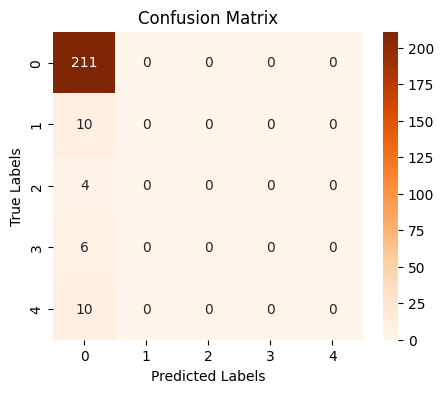

In [12]:
# Running active learning loops
print("Running active learning using random sampling strategy: ")
f1_scores_random_sampling, accuracy_random_sampling = active_learning_strategy(random_sampling, X_initial.copy() ,y_initial.copy() ,X_pool.copy(), y_pool.copy(), X_test, y_test)

## **Plotting the Results of the Random Sampling Cycle**

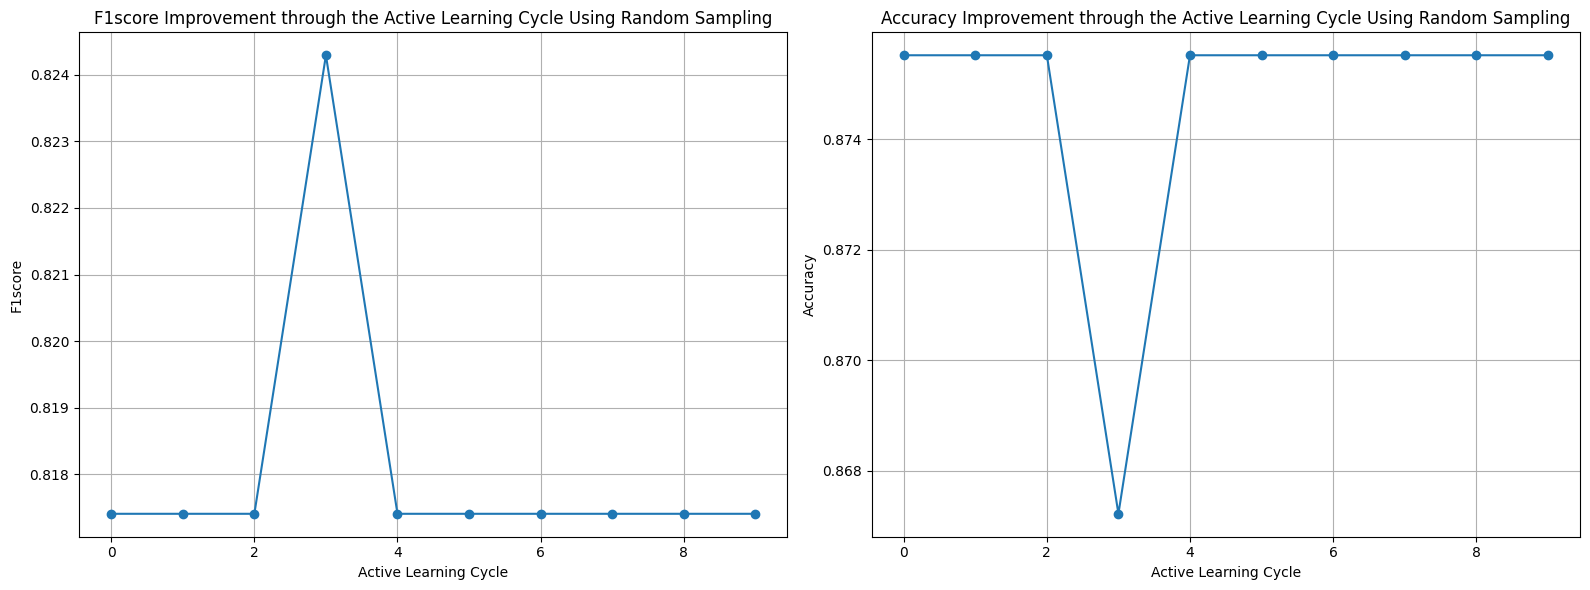

In [13]:
plot_metrics(f1_scores_random_sampling, accuracy_random_sampling, "Random Sampling")

## **The Active Learning Cycle Using Entropy Sampling**

Running active learning using entropy sampling: 


<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
384/384 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9018 - loss: 0.6935
577/577 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8037 - loss: 0.8613
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 1: 
F1 Score: 0.8153388965047704
Accuracy: 0.8713692946058091



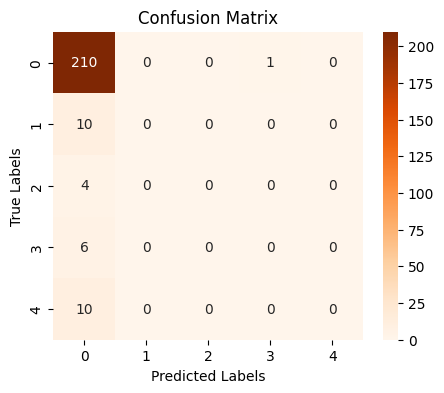

537/537 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


464/464 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7558 - loss: 1.0314
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 2: 
F1 Score: 0.8262494860005234
Accuracy: 0.8672199170124482



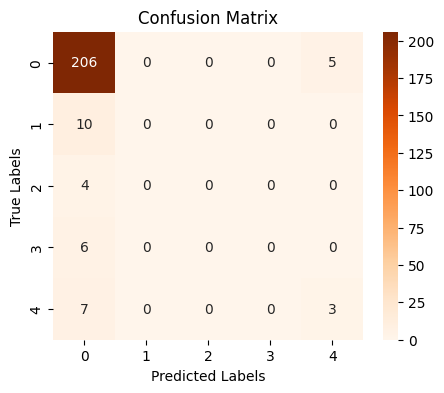

497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


504/504 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7700 - loss: 1.1897
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 3: 
F1 Score: 0.818143877255621
Accuracy: 0.8381742738589212



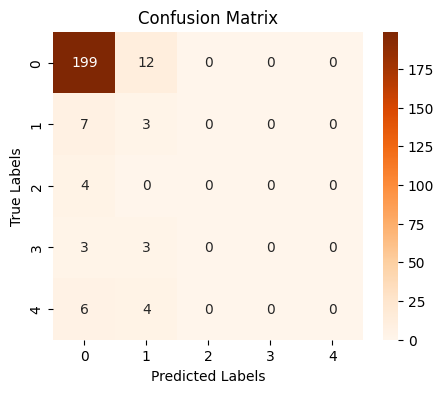

457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


544/544 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7914 - loss: 0.9560
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Iteration 4: 
F1 Score: 0.8179260639248784
Accuracy: 0.8547717842323651



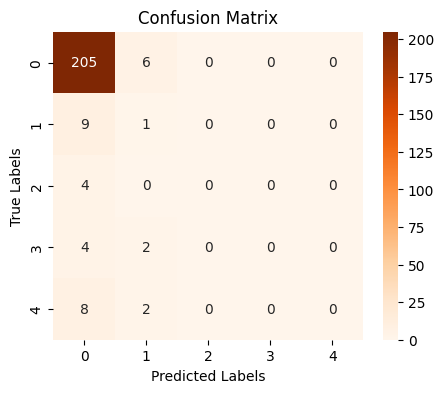

417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


584/584 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8098 - loss: 1.0086
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 5: 
F1 Score: 0.8153388965047704
Accuracy: 0.8713692946058091



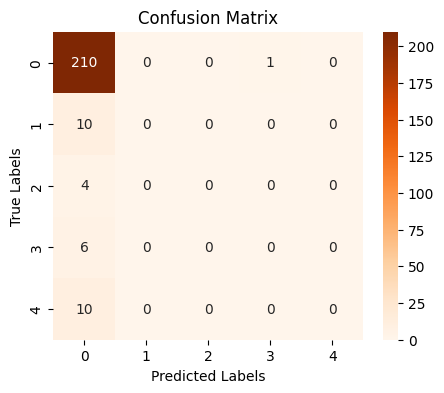

377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8128 - loss: 0.8957
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 6: 
F1 Score: 0.8192214626786026
Accuracy: 0.8755186721991701



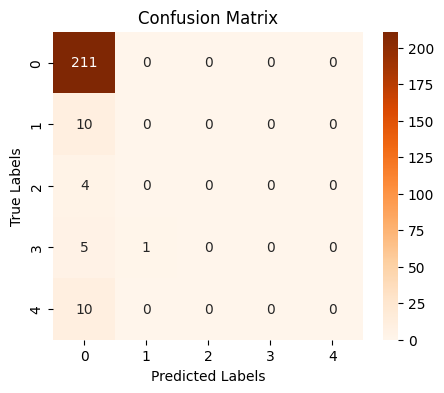

337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


664/664 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8530 - loss: 0.7953
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 7: 
F1 Score: 0.8174090258142694
Accuracy: 0.8755186721991701



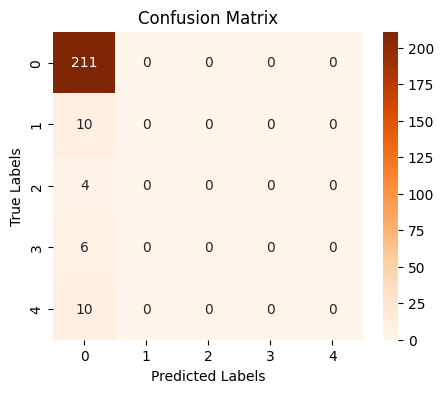

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8310 - loss: 0.7992
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 8: 
F1 Score: 0.8174090258142694
Accuracy: 0.8755186721991701



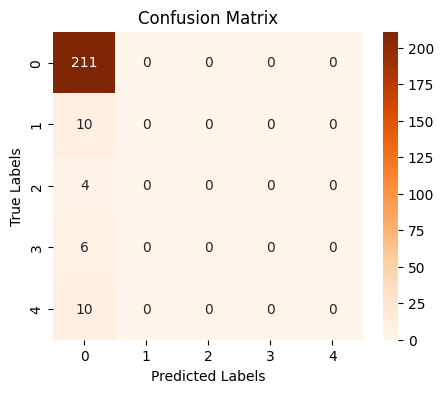

257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


744/744 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8404 - loss: 0.7142
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 9: 
F1 Score: 0.8174090258142694
Accuracy: 0.8755186721991701



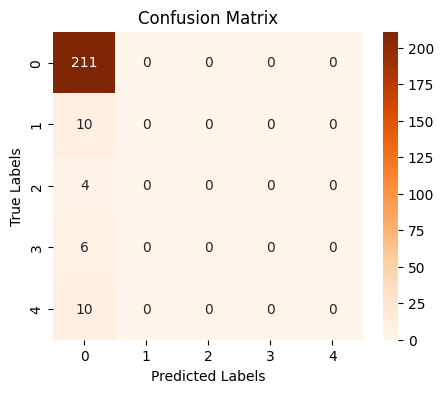

217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


784/784 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8346 - loss: 0.7023
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 10: 
F1 Score: 0.8240663900414937
Accuracy: 0.8755186721991701



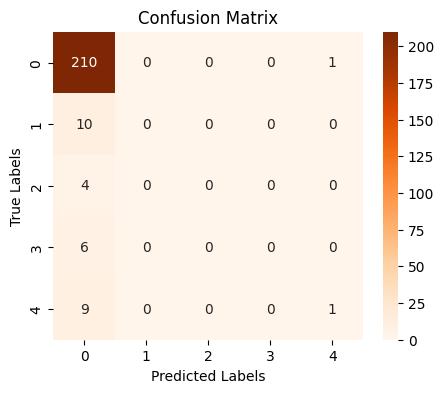

In [11]:
# Running active learning loops
print("Running active learning using entropy sampling: ")
f1_scores_entropy, accuracy_entropy = active_learning_strategy(entropy_sampling, X_initial.copy() ,y_initial.copy() ,X_pool.copy(), y_pool.copy(), X_test, y_test)

## **Plotting the Results of the Entropy Sampling Cycle**

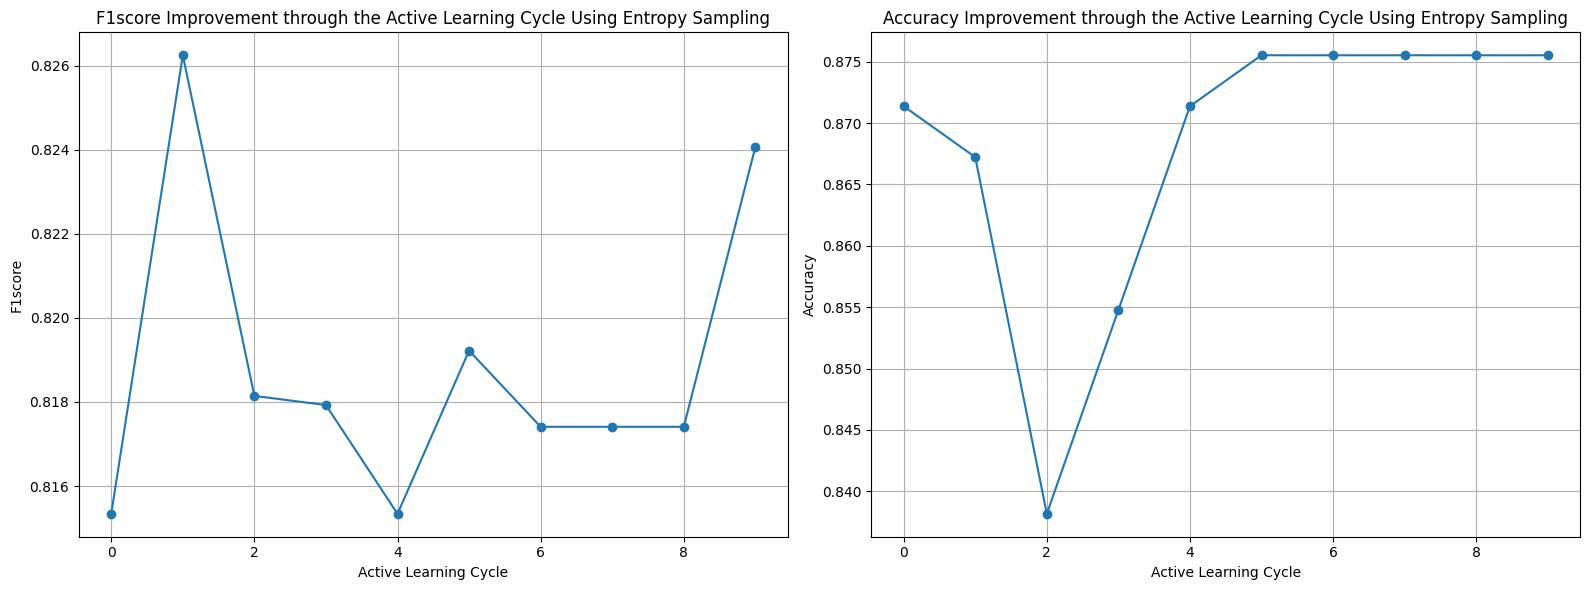

In [12]:
plot_metrics(f1_scores_entropy, accuracy_entropy, "Entropy Sampling")

## **The Active Learning Cycle Using Margin Sampling**

Running active learning using margin sampling: 


<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
384/384 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8673 - loss: 0.7788
577/577 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8438 - loss: 0.7572
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 1: 
F1 Score: 0.8153388965047704
Accuracy: 0.8713692946058091



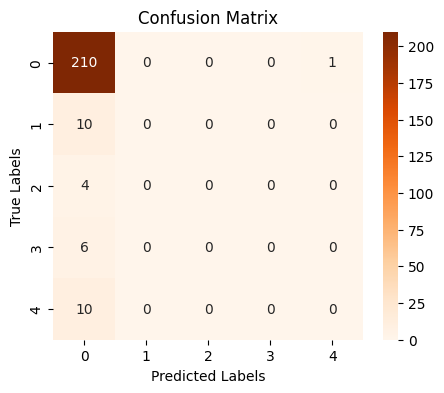

537/537 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


464/464 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8097 - loss: 0.9191
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 2: 
F1 Score: 0.8364501032607665
Accuracy: 0.8630705394190872



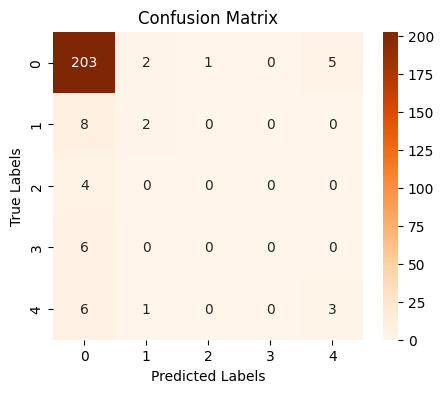

497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


504/504 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7720 - loss: 0.8402
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Iteration 3: 
F1 Score: 0.8174090258142694
Accuracy: 0.8755186721991701



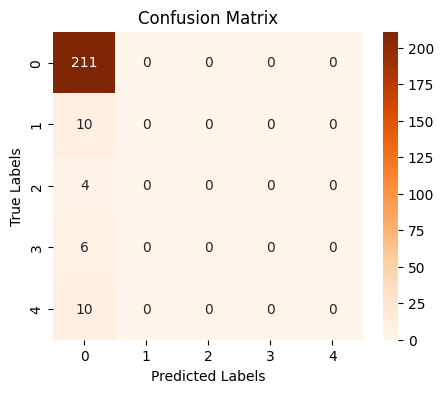

457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


544/544 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7530 - loss: 0.8709
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 4: 
F1 Score: 0.8267657855756226
Accuracy: 0.8796680497925311



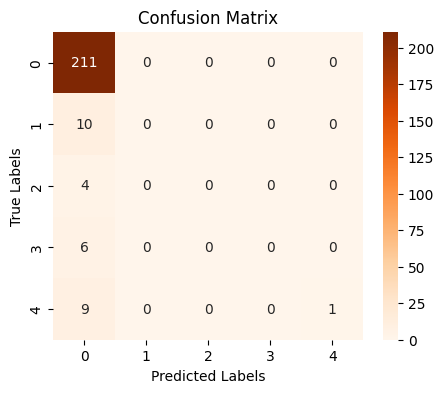

417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


584/584 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7927 - loss: 0.9633
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 5: 
F1 Score: 0.8153388965047704
Accuracy: 0.8713692946058091



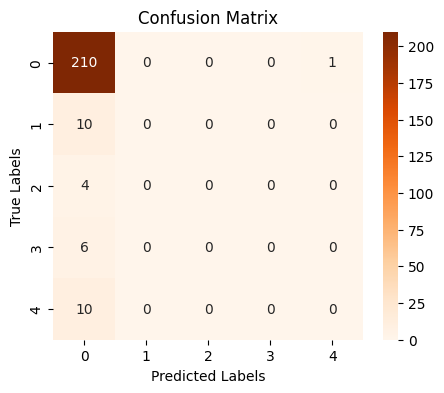

377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8173 - loss: 0.9706
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 6: 
F1 Score: 0.8174090258142694
Accuracy: 0.8755186721991701



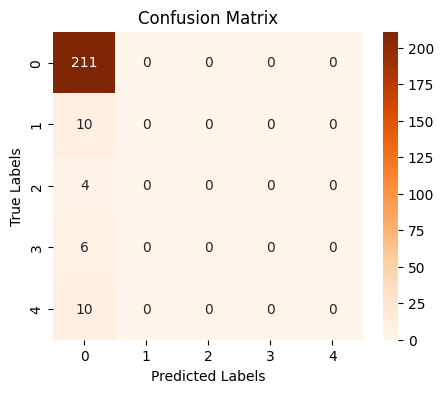

337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


664/664 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8148 - loss: 0.8058
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 7: 
F1 Score: 0.8132595666205624
Accuracy: 0.8672199170124482



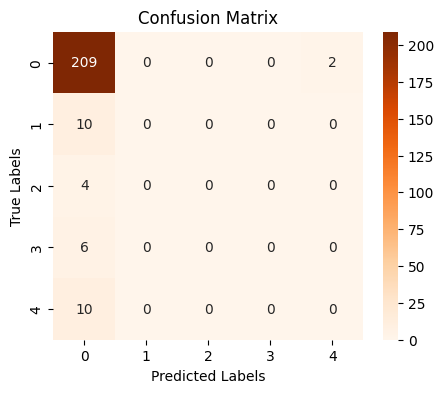

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8250 - loss: 0.8075
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 8: 
F1 Score: 0.8153388965047704
Accuracy: 0.8713692946058091



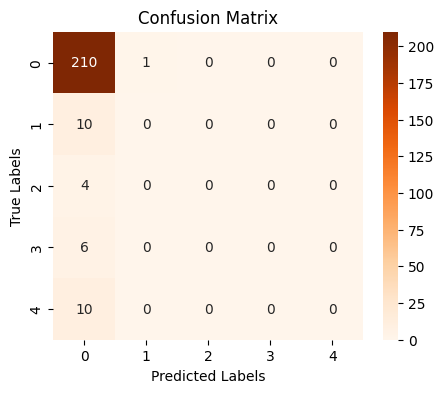

257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


744/744 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8424 - loss: 0.7752
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 9: 
F1 Score: 0.8174090258142694
Accuracy: 0.8755186721991701



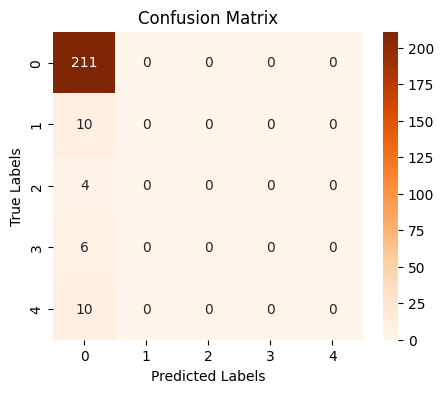

217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


784/784 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8467 - loss: 0.7969
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 10: 
F1 Score: 0.8174090258142694
Accuracy: 0.8755186721991701



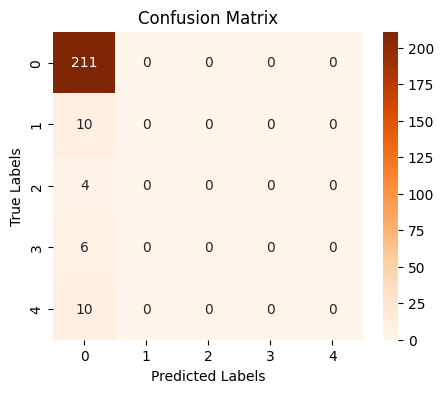

In [11]:
print("Running active learning using margin sampling: ")
f1_scores_margin, accuracy_margin = active_learning_strategy(margin_sampling, X_initial.copy() ,y_initial.copy() ,X_pool.copy(), y_pool.copy(), X_test, y_test)

## **Plotting the Results of the Margin Sampling Cycle**

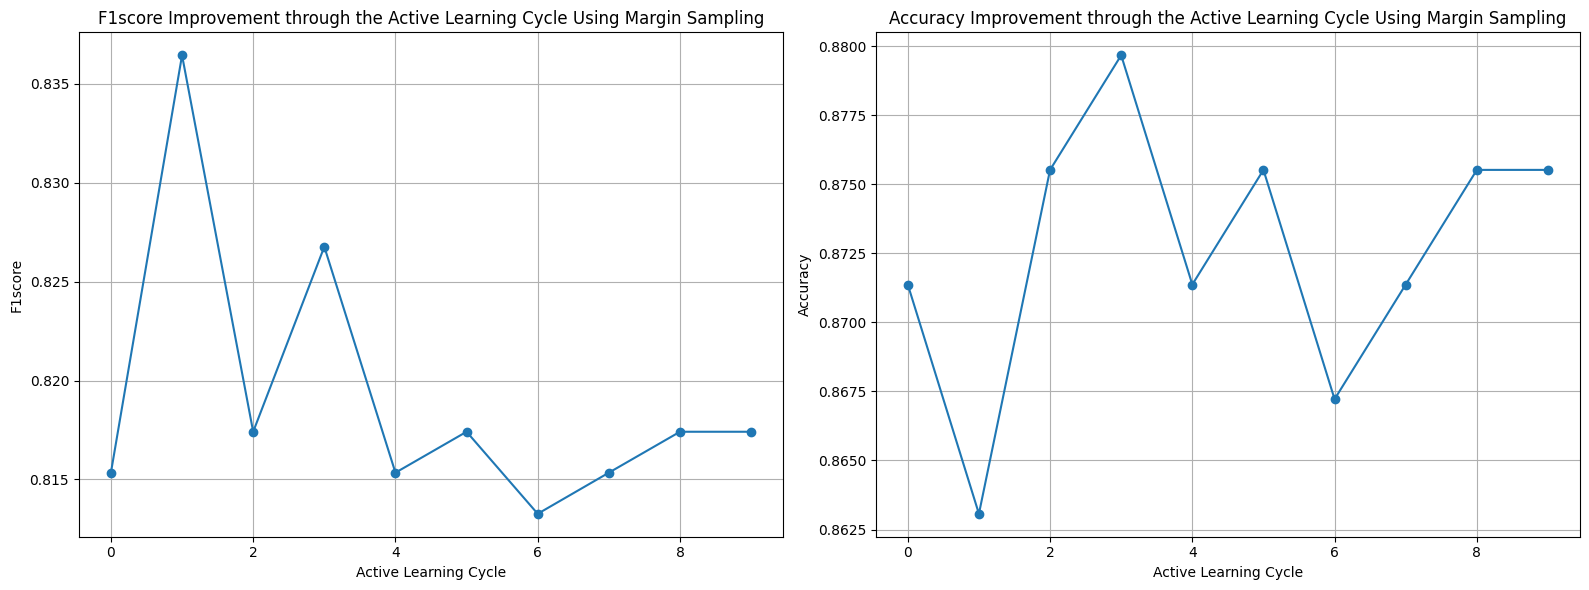

In [12]:
plot_metrics(f1_scores_margin, accuracy_margin, "Margin Sampling")

## **The Active Learning Cycle Using Uncertainty Sampling**

Running active learning using uncertainty sampling: 


<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
384/384 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8419 - loss: 0.7744
577/577 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8108 - loss: 0.9518
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Iteration 1: 
F1 Score: 0.816810747802978
Accuracy: 0.8630705394190872



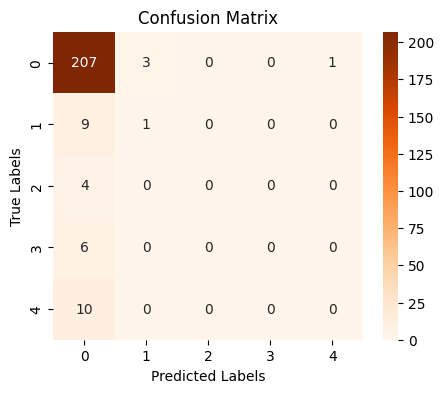

537/537 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


464/464 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7453 - loss: 0.9994
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 2: 
F1 Score: 0.8153388965047704
Accuracy: 0.8713692946058091



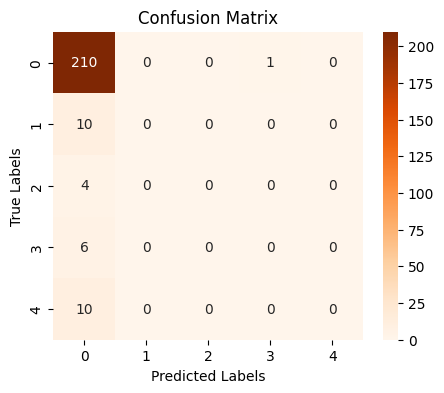

497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


504/504 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8024 - loss: 1.0279
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 3: 
F1 Score: 0.8174090258142694
Accuracy: 0.8755186721991701



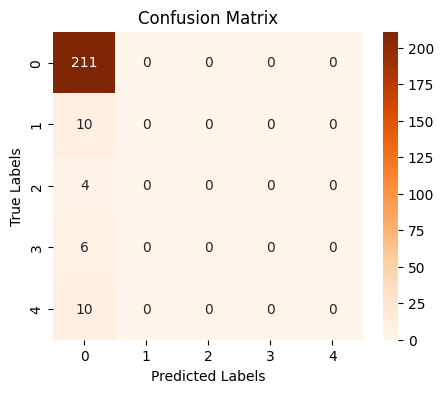

457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


544/544 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8057 - loss: 0.9416
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 4: 
F1 Score: 0.8162820825744916
Accuracy: 0.8547717842323651



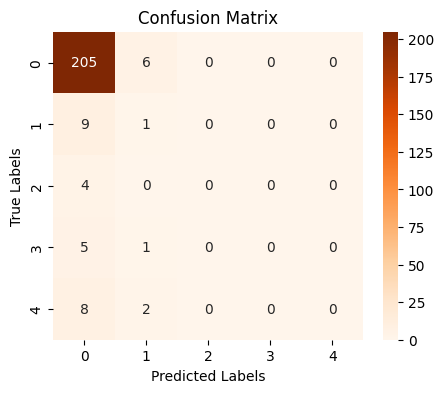

417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


584/584 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8089 - loss: 0.8369
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 5: 
F1 Score: 0.8174090258142694
Accuracy: 0.8755186721991701



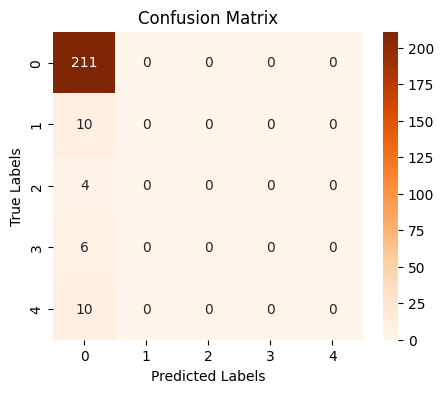

377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


624/624 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8549 - loss: 0.7454
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 6: 
F1 Score: 0.820136392091253
Accuracy: 0.8340248962655602



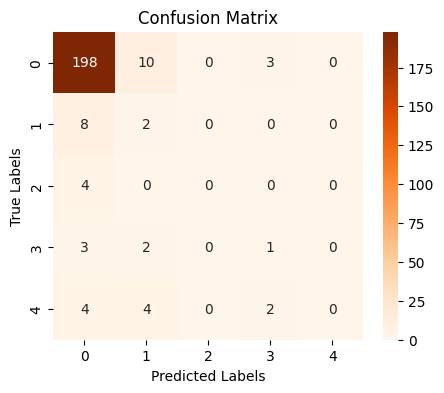

337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


664/664 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7971 - loss: 0.9034
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Iteration 7: 
F1 Score: 0.8132595666205624
Accuracy: 0.8672199170124482



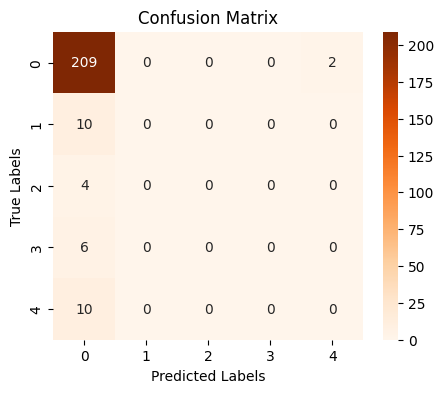

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8317 - loss: 0.8975
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 8: 
F1 Score: 0.8129816241849438
Accuracy: 0.8630705394190872



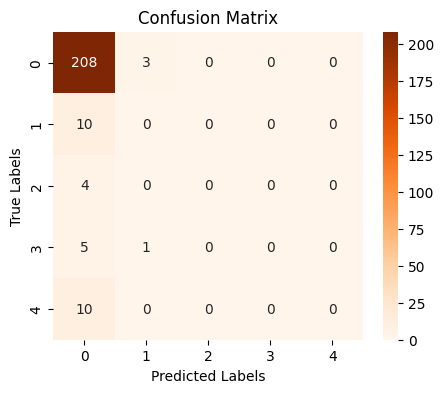

257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


744/744 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7835 - loss: 0.8605
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 9: 
F1 Score: 0.8174090258142694
Accuracy: 0.8755186721991701



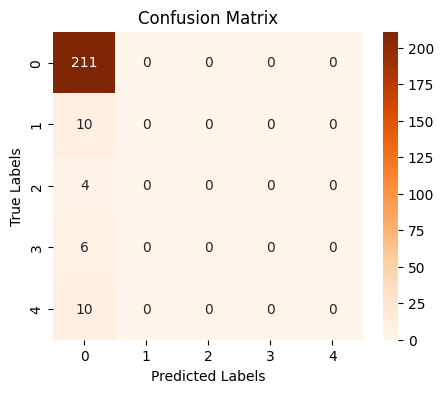

217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


784/784 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8496 - loss: 0.6874
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 10: 
F1 Score: 0.8227333320816357
Accuracy: 0.8630705394190872



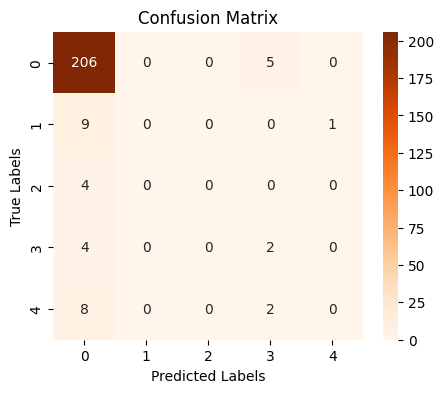

In [11]:
print("Running active learning using uncertainty sampling: ")
f1_scores_uncertainty, accuracy_uncertainty = active_learning_strategy(uncertainty_sampling, X_initial.copy() ,y_initial.copy() ,X_pool.copy(), y_pool.copy(), X_test, y_test)

## **Plotting the Results of the Uncertainty Sampling Cycle** 

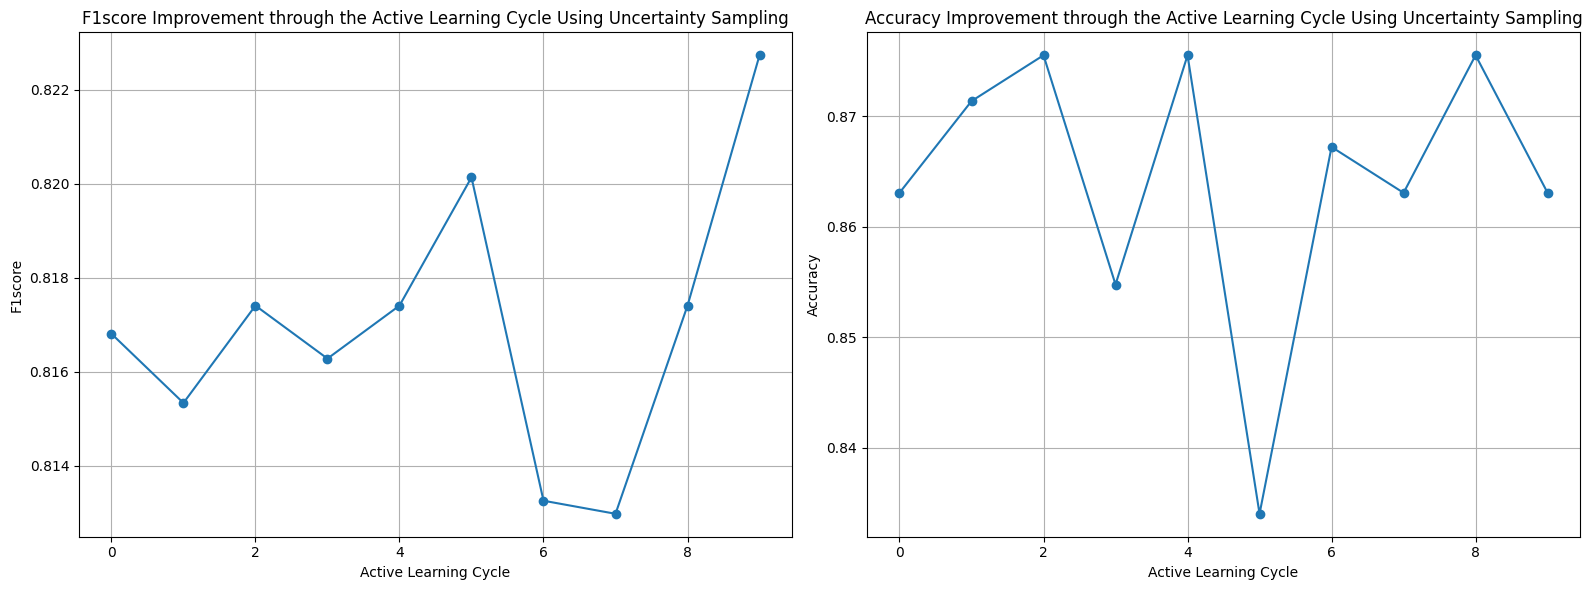

In [12]:
plot_metrics(f1_scores_uncertainty, accuracy_uncertainty, "Uncertainty Sampling")

## **The Active Learning Cycle Using Consensus Entropy Sampling**

Running active learning using consensus entropy sampling: 


<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
384/384 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8459 - loss: 0.7560
577/577 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7916 - loss: 0.8899
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 1: 
F1 Score: 0.8174090258142694
Accuracy: 0.8755186721991701



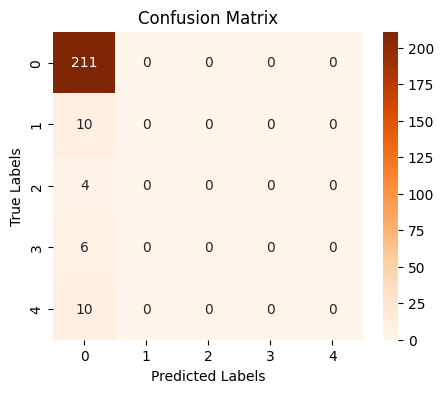

537/537 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


464/464 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7871 - loss: 0.9598
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 2: 
F1 Score: 0.8174090258142694
Accuracy: 0.8755186721991701



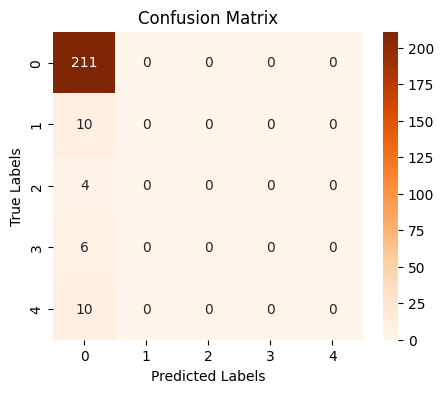

497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


504/504 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7366 - loss: 0.8957
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Iteration 3: 
F1 Score: 0.8187176845173447
Accuracy: 0.8672199170124482



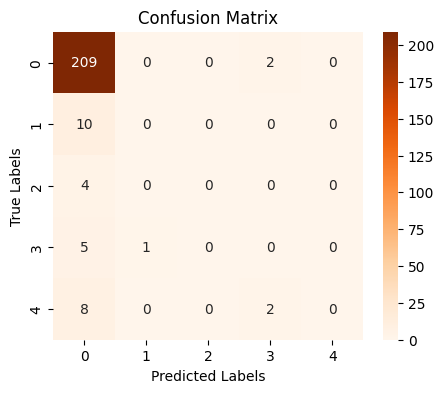

457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


544/544 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7867 - loss: 0.9042
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 4: 
F1 Score: 0.8301772915880801
Accuracy: 0.8630705394190872



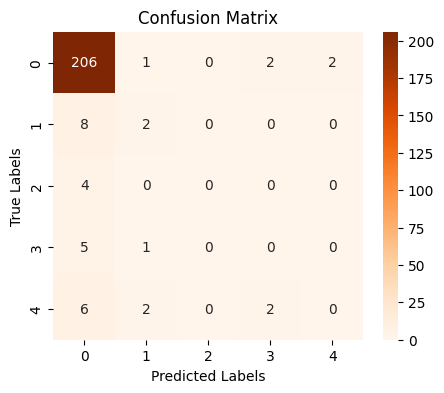

417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


584/584 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7883 - loss: 0.9475
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 5: 
F1 Score: 0.8238417907038715
Accuracy: 0.8547717842323651



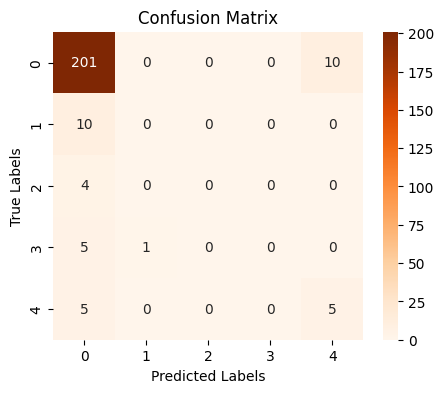

377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8025 - loss: 0.8393
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 6: 
F1 Score: 0.8174090258142694
Accuracy: 0.8755186721991701



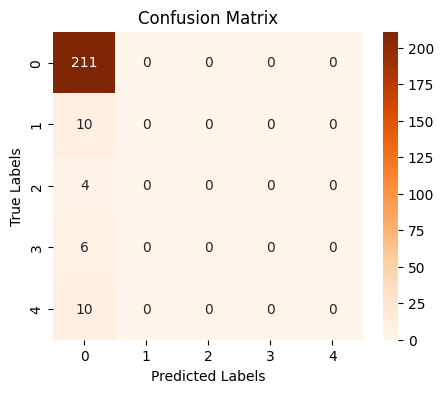

337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


664/664 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8190 - loss: 0.9502
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 7: 
F1 Score: 0.8174090258142694
Accuracy: 0.8755186721991701



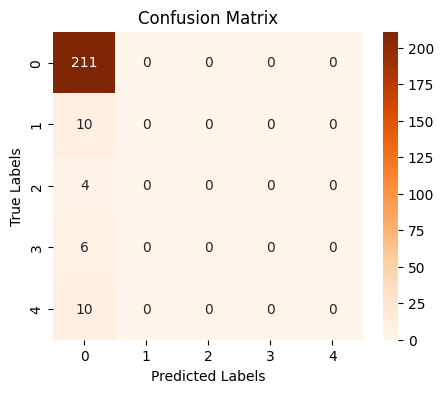

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8277 - loss: 0.7879
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 8: 
F1 Score: 0.8174090258142694
Accuracy: 0.8755186721991701



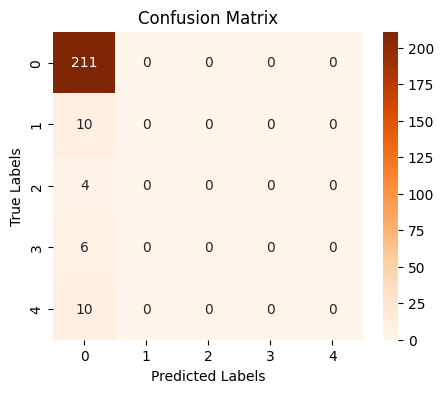

257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


744/744 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8449 - loss: 0.7280
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 9: 
F1 Score: 0.8171507607192254
Accuracy: 0.8713692946058091



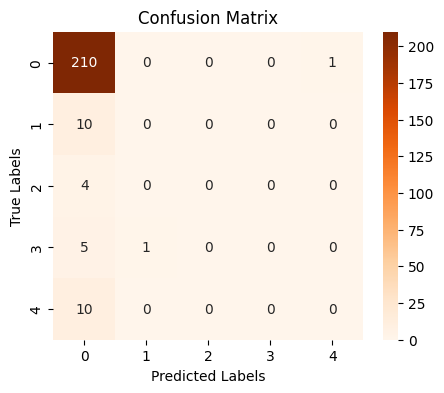

217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-4-28be8938dad7>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


784/784 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8433 - loss: 0.7241
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Iteration 10: 
F1 Score: 0.8090730586840545
Accuracy: 0.8589211618257261



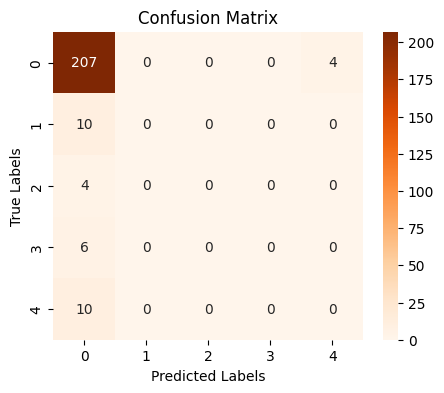

In [11]:
print("Running active learning using consensus entropy sampling: ")
f1_scores_consensus_entropy, uncertainty_consensus_entropy= active_learning_strategy(consensus_entropy_sampling, X_initial.copy() ,y_initial.copy() ,X_pool.copy(), y_pool.copy(), X_test, y_test)

## **Plotting the Results of the Consensus Entropy Sampling Cycle**

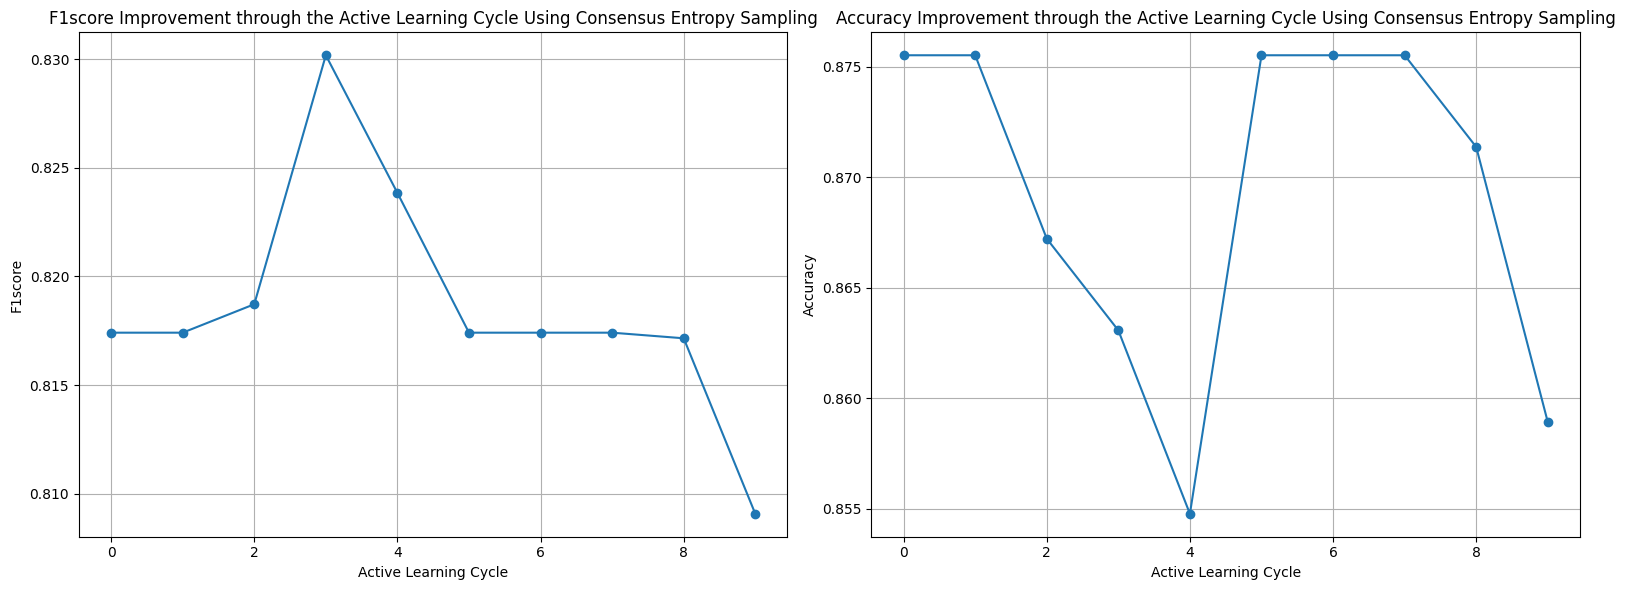

In [12]:
plot_metrics(f1_scores_consensus_entropy, uncertainty_consensus_entropy, "Consensus Entropy Sampling")

## **Putting all Plots Together** 

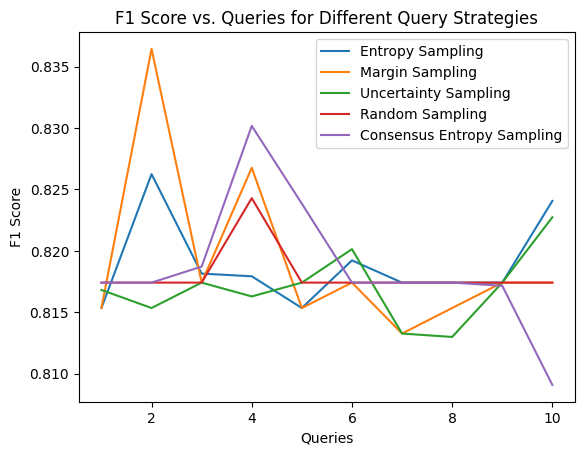

In [14]:
n_queries = 10
# Plot F1 scores for each query
plt.plot(range(1, n_queries + 1), f1_scores_entropy, label='Entropy Sampling')
plt.plot(range(1, n_queries + 1), f1_scores_margin, label='Margin Sampling')
plt.plot(range(1, n_queries + 1), f1_scores_uncertainty, label='Uncertainty Sampling')
plt.plot(range(1, n_queries + 1), f1_scores_random_sampling, label='Random Sampling')
plt.plot(range(1, n_queries + 1), f1_scores_consensus_entropy, label='Consensus Entropy Sampling')
plt.xlabel('Queries')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Queries for Different Query Strategies')
plt.legend()
plt.show()

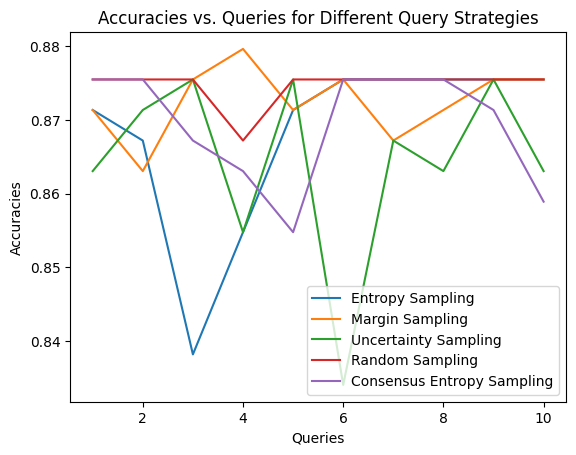

In [15]:
# Plot accuracies over queries
plt.plot(range(1, n_queries + 1), accuracy_entropy, label='Entropy Sampling')
plt.plot(range(1, n_queries + 1), accuracy_margin, label='Margin Sampling')
plt.plot(range(1, n_queries + 1), accuracy_uncertainty, label='Uncertainty Sampling')
plt.plot(range(1, n_queries + 1), accuracy_random_sampling, label='Random Sampling')
plt.plot(range(1, n_queries + 1), uncertainty_consensus_entropy, label='Consensus Entropy Sampling')
plt.xlabel('Queries')
plt.ylabel('Accuracies')
plt.title('Accuracies vs. Queries for Different Query Strategies')
plt.legend()
plt.show()